In [1]:
import torch
import torch.nn as nn
import fg_pre_process as prep
from fg_data_list import ImageList
import numpy as np
from torchvision import transforms

import fg_model_no_class as model_no

from sklearn.svm import LinearSVC

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    # ResizeImage(resize_size),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  ])

## Define model

In [3]:
class fine_net(nn.Module):
    def __init__(self, total_classes):
        super(fine_net, self).__init__()
        self.model_fc = model_no.Resnet50Fc()
        feature_len = self.model_fc.output_num()
        self.bottleneck_0 = nn.Linear(feature_len, 256)
        self.bottleneck_0.weight.data.normal_(0, 0.005)
        self.bottleneck_0.bias.data.fill_(0.1)
        self.bottleneck_layer = nn.Sequential(self.bottleneck_0, nn.ReLU())
        self.classifier_layer = predictor(256, total_classes)

    def forward(self, x):
        features = self.model_fc(x)
        out_bottleneck = self.bottleneck_layer(features)
        logits = self.classifier_layer(out_bottleneck)
        return out_bottleneck.detach(), logits.detach()
    
class predictor(nn.Module):
    def __init__(self, feature_len, cate_num):
        super(predictor, self).__init__()
        self.classifier = nn.Linear(feature_len, cate_num)
        self.classifier.weight.data.normal_(0, 0.01)
        self.classifier.bias.data.fill_(0.0)

    def forward(self, features):
        activations = self.classifier(features)
        return (activations)

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        


## Load the source and target data

In [7]:
dataset_list = ImageList("/newfoundland/tarun/datasets/birds/", open("./data/cub200/cub200_drawing.txt").readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
dataset_loader_source = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=True, num_workers=16, drop_last=True)

dataset_list = ImageList("/newfoundland/tarun/datasets/birds/", open("./data/cub200/cub200_2011.txt").readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
dataset_loader_target = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=True, num_workers=16, drop_last=True)

## Collect features for CDAN model

In [8]:
load_model = "snapshot/cub2011_syncWithCluster/CDAN_drawingcub_tau0-007_simcoeff0_LL0/best_model.pth.tar"
model = fine_net(200)
saved_state_dict = torch.load(load_model)
model.load_state_dict(saved_state_dict, strict=True)
model.eval()
model.cuda()

cdan_source_features = []
for images , _ in dataset_loader_source:
    images = images.cuda()
    features , _ = model(images)
    cdan_source_features.append(features)
cdan_source_features = torch.cat(cdan_source_features)
  
    
accuracy = AverageMeter()    
cdan_target_features = []
for images , labels in dataset_loader_target:
    images = images.cuda()
    features , logits = model(images)
    preds = logits.argmax(1)
    accuracy.update(torch.sum(preds == labels.cuda())*1.0/len(images) , len(images))
    cdan_target_features.append(features)
cdan_target_features = torch.cat(cdan_target_features)    

print(accuracy.avg)
cdan_features = torch.cat([cdan_source_features , cdan_target_features]).cpu().numpy()
cdan_labels = np.array([0]*len(cdan_source_features) + [1]*len(cdan_target_features))

tensor(0.5278, device='cuda:0')


In [ ]:
clf = LinearSVC(max_iter=5e4)
clf.fit(cdan_features, cdan_labels)
clf.score(cdan_features, cdan_labels)

## Collect features for ILA model

In [ ]:
load_model = "snapshot/cub2011_syncWithCluster/CDAN_drawingcub_tau0-007_simcoeff0-1_LL0/best_model.pth.tar"
model = fine_net(200)
saved_state_dict = torch.load(load_model)
model.load_state_dict(saved_state_dict, strict=True)
model.eval()
model.cuda()

ila_source_features = []
for images , _ in dataset_loader_source:
    images = images.cuda()
    features , _ = model(images)
    ila_source_features.append(features)
ila_source_features = torch.cat(ila_source_features)
    
accuracy = AverageMeter()
ila_target_features = []
for images , labels in dataset_loader_target:
    images = images.cuda()
    labels = labels.cuda()
    features, logits = model(images)
    preds = logits.argmax(1)
    accuracy.update(torch.sum(preds == labels.cuda())*1.0/len(images) , len(images))
    ila_target_features.append(features)
ila_target_features = torch.cat(ila_target_features)    

print(accuracy.avg)
ila_features = torch.cat([ila_source_features , ila_target_features]).cpu().numpy()
ila_labels = np.array([0]*len(ila_source_features) + [1]*len(ila_target_features))

In [ ]:
clf = LinearSVC(max_iter=5e4)
clf.fit(ila_features, ila_labels)
clf.score(ila_features, ila_labels)

## Source only baseline model

In [ ]:
load_model = "/newfoundland/tarun/ila_old_saved_models/cub2011_old/drawing_Only/best_model.pth.tar"
model = fine_net(200)
saved_state_dict = torch.load(load_model)
saved_state_dict = {k.partition("module.")[-1]:v for k,v in saved_state_dict.items()}
model.load_state_dict(saved_state_dict, strict=True)
model.eval()
model.cuda()

baseline_source_features = []
for images , _ in dataset_loader_source:
    images = images.cuda()
    features , _ = model(images)
    baseline_source_features.append(features)
baseline_source_features = torch.cat(baseline_source_features)
    
accuracy = AverageMeter()
baseline_target_features = []
for images , labels in dataset_loader_target:
    images = images.cuda()
    labels = labels.cuda()
    features, logits = model(images)
    preds = logits.argmax(1)
    accuracy.update(torch.sum(preds == labels.cuda())*1.0/len(images) , len(images))
    baseline_target_features.append(features)
baseline_target_features = torch.cat(baseline_target_features)    

print(accuracy.avg)
baseline_features = torch.cat([baseline_source_features , baseline_target_features]).cpu().numpy()
baseline_labels = np.array([0]*len(baseline_source_features) + [1]*len(baseline_target_features))

In [ ]:
clf = LinearSVC(max_iter=5e4)
clf.fit(baseline_features, baseline_labels)
clf.score(baseline_features, baseline_labels)

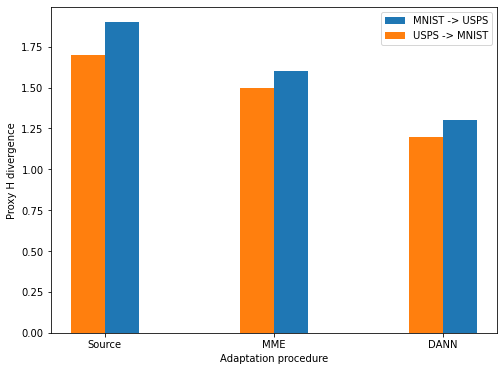

In [20]:
MS = [1.9,1.6,1.3]
SM = [1.7,1.5,1.2]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))

labels = ["Source" , "MME" , "DANN"]

plt.bar(np.array(range(len(MS)))+.1 , MS, width=.2 , label="MNIST -> USPS")
plt.bar(np.array(range(len(SM)))-.1 , SM, width=.2, label="USPS -> MNIST")
plt.xticks(range(len(MS)) , labels)
plt.legend()

plt.xlabel("Adaptation procedure")
plt.ylabel("Proxy H divergence")
fig.show()